## 자연어 전처리-영어

관련 패키지 로드

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer#토큰화
from tensorflow.keras.preprocessing.sequence import pad_sequences#패딩
from sklearn.preprocessing import LabelEncoder#정답 숫자화
from sklearn.model_selection import train_test_split#데이더 분할
from tensorflow.keras.utils import to_categorical#정답을 원_핫 인코딩화
import numpy as np#넘파이 
from nltk.corpus import stopwords#불용어 메소드
from bs4 import BeautifulSoup#마크업 단어를 정리하기 위한 목적
import re#문자 정규표준
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

전처리 메소드 구축

In [2]:
def preprocessing(X_text, remove_stopwords=False):
    X_text = BeautifulSoup(X_text, 'lxml').get_text()#마크업언더 정리
    X_text = re.sub("[^a-zA-Z]", " ", X_text)#영어 숫자 말고 제거
    words = X_text.lower().split()#소문자화
    if remove_stopwords:
        stops = set(stopwords.words('english'))#불용어 로드
        #stops.add(불용어 문자열)#추가 불용어가 필요할 기록<문자열1개>
        words = [w for w in words if not w in stops]
        clean_text = ' '.join(words)
    else:
        clean_text = ' '.join(words)
        
    return clean_text

In [3]:
import pandas as pd
data = pd.read_csv('spam.csv',encoding='latin1')[['v1','v2']]
data=data.rename(columns = {'v1':'y', 'v2' : 'X'})#데이터 프레임 열이름 변경

In [4]:
data['clean_X']=data['X'].apply(lambda x : preprocessing(X_text=x, remove_stopwords=True))#만들어진 함수이용 data 1차 정리

In [5]:
data['y_name']=data['y']#정답 이름 기록
data['encoder_y']=LabelEncoder().fit_transform(data['y'])#정답 숫자화
data['categorical_y']=list(to_categorical(data['encoder_y']))#정답 다중값 희소행렬정리

In [6]:
data.isnull().values.any()#결측치 확인

False

In [7]:
data['clean_X'].nunique(), data['y'].nunique()#중복 확인

(5055, 2)

In [8]:
data=data.drop_duplicates(subset=['X'])#중복 제거
data['clean_X'] = data['clean_X'].str.replace("[^a-zA-Z0-9 ]","")#영어 숫자 말고 제거
data['clean_X'] = data['clean_X'].str.replace('^ +', "")#문장 앞의 공백 제거
data['clean_X'].replace('', np.nan, inplace=True)#비어있는 문자열 NaN화
data = data.dropna(how = 'any')#NaN_ data 정리

C:\Users\user\AppData\Local\Temp/ipykernel_19056/3168660846.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X'] = data['clean_X'].str.replace("[^a-zA-Z0-9 ]","")#영어 숫자 말고 제거
C:\Users\user\AppData\Local\Temp/ipykernel_19056/3168660846.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X'] = data['clean_X'].str.replace('^ +', "")#문장 앞의 공백 제거


In [9]:
Y=np.array(data['encoder_y'])#이진 분류
#Y=to_categorical(data['encoder_y'])#다중 분류

In [10]:
X=np.array(data['clean_X'])#입력 정리

In [11]:
x_data,test_x,y_data,test_y = train_test_split(X,Y,test_size=0.3,stratify=Y,random_state=0)#태스트 데이터 분할

In [12]:
train_x,val_x,train_y,val_y = train_test_split(x_data,y_data,test_size=0.2,stratify=y_data,random_state=0)#학습데이터,검증데이터 분할

In [13]:
tk = Tokenizer()
tk.fit_on_texts(train_x)#입력된 데이터 내의 단어모음집 구축

In [14]:
n=len([d for d in sorted(list(tk.word_counts.items()),key=lambda x:x[1]) if d[1]>4])+1#단어모음집중 4번이하 제거 단어갯수기록

In [15]:
token=Tokenizer(n)#정의한 단어의 수를 기반으로 문서 정리
token.fit_on_texts(train_x)#학습 데이터를 이용하여 단어모음집을 가진 장치 완성

In [16]:
token_train_x=token.texts_to_sequences(train_x)#같은 사전을 이용하여 같은 범주의 단어들을 가지고있는 단어 표현
token_test_x=token.texts_to_sequences(test_x)#같은 사전을 이용하여 같은 범주의 단어들을 가지고있는 단어 표현
token_val_x=token.texts_to_sequences(val_x)#같은 사전을 이용하여 같은 범주의 단어들을 가지고있는 단어 표현

In [17]:
drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]#빈문자열 위치 확인
drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1]#빈문자열 위치 확인
drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1]#빈문자열 위치 확인

In [18]:
token_train_x = np.delete(token_train_x, drop_train, axis=0)#빈문자열 제거
train_y = np.delete(train_y, drop_train, axis=0)#빈문자열 제거
token_test_x = np.delete(token_test_x, drop_test, axis=0)#빈문자열 제거
test_y = np.delete(test_y, drop_test, axis=0)#빈문자열 제거
token_val_x = np.delete(token_val_x, drop_val, axis=0)#빈문자열 제거
val_y = np.delete(val_y, drop_val, axis=0)#빈문자열 제거

C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
w_l=len(pad_sequences(token_train_x)[0])#학습 데이터중 가장 긴 문장 길이 확인

In [20]:
train_inputs = pad_sequences(token_train_x,maxlen=w_l)#모든 문장의 길이가 똑같게 만든다
test_inputs = pad_sequences(token_test_x,maxlen=w_l)#모든 문장의 길이가 똑같게 만든다
val_inputs = pad_sequences(token_val_x,maxlen=w_l)#모든 문장의 길이가 똑같게 만든다

In [21]:
train_outputs=train_y#용어 정리
test_outputs=test_y#용어 정리
val_outputs=val_y#용어 정리

In [22]:
(train_inputs.shape,train_outputs.shape),(test_inputs.shape,test_outputs.shape),(val_inputs.shape,val_outputs.shape)

(((2844, 46), (2844,)), ((1513, 46), (1513,)), ((710, 46), (710,)))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, Dense, LSTM,BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_eg_p.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [24]:
model = Sequential()
model.add(Embedding(n, 100))
model.add(LSTM(128,dropout=0.5,return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128,dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_inputs, train_outputs, epochs=100, callbacks=[es, mc], batch_size=60,validation_data=(val_inputs,val_outputs))

Epoch 1/100
48/48 [==============================] - 12s 153ms/step - loss: 0.2451 - acc: 0.9005 - val_loss: 0.3374 - val_acc: 0.8732

Epoch 00001: val_acc improved from -inf to 0.87324, saving model to best_model_eg_p.h5
Epoch 2/100
48/48 [==============================] - 6s 124ms/step - loss: 0.0582 - acc: 0.9852 - val_loss: 0.2827 - val_acc: 0.8718

Epoch 00002: val_acc did not improve from 0.87324
Epoch 3/100
48/48 [==============================] - 6s 127ms/step - loss: 0.0332 - acc: 0.9919 - val_loss: 0.3143 - val_acc: 0.8718

Epoch 00003: val_acc did not improve from 0.87324
Epoch 4/100
48/48 [==============================] - 6s 121ms/step - loss: 0.0210 - acc: 0.9947 - val_loss: 0.3563 - val_acc: 0.8718

Epoch 00004: val_acc did not improve from 0.87324
Epoch 5/100
48/48 [==============================] - 6s 126ms/step - loss: 0.0159 - acc: 0.9954 - val_loss: 0.1621 - val_acc: 0.9380

Epoch 00005: val_acc improved from 0.87324 to 0.93803, saving model to best_model_eg_p.h5
Ep

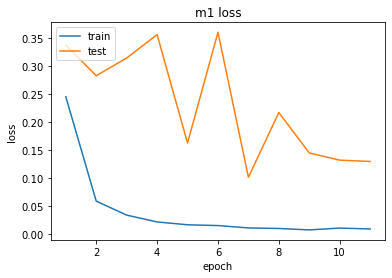

In [26]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('m1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
loaded_model_p = load_model('best_model_eg_p.h5')
loaded_model_p.evaluate(test_inputs,test_outputs)[1]

48/48 [==============================] - 2s 24ms/step - loss: 0.0918 - acc: 0.9822


0.9821546673774719

In [28]:
def 문장_전처리(문장):
    문장 = preprocessing(X_text=문장, remove_stopwords=True)
    encoded = token.texts_to_sequences([문장])
    pad_new = pad_sequences(encoded, maxlen = w_l) 
    score = float(loaded_model_p.predict(pad_new))
    if(score > 0.5):
        print(f"{score * 100:.2f}% 확률로 스팸입니다.\n")
    else:
        print(f"{(1 - score) * 100:.2f}% 확률로 정상메일 입니다.\n")

In [29]:
문장_전처리("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's")

99.04% 확률로 스팸입니다.



In [30]:
문장_전처리('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

99.85% 확률로 정상메일 입니다.



In [31]:
n

984

In [32]:
w_l_data = list(token.word_index.keys())

In [33]:
w_l_data.insert(0,'OOV')

In [34]:
w_l_data=w_l_data[:984]

In [35]:
ws = loaded_model_p.layers[0].get_weights()[0]

In [36]:
len(ws), len(w_l_data)

(984, 984)

In [37]:
import io
out_v = io.open('v_data_p.tsv','w',encoding='utf-8')
out_w = io.open('w_data_p.tsv','w',encoding='utf-8')
for i, w in enumerate(w_l_data):
    if i == 0:
        continue
    vec = ws[i]
    out_v.write('\t'.join([str(i) for i in vec])+'\n')
    out_w.write(w+'\n')
out_v.close()
out_w.close()